# [WUM] Praca domowa nr 7 - klasteryzacja
### Mateusz Polakowski

Poniżej zajmiemy się zadaniem analizy skupień na spreparowanym zbiorze danych przy użyciu funkcji *make_blobs* modułu *sklearn.datasets*. Utworzy ona zadaną liczbę kulistych klastrów (w przestrzeni dwuwymiarowej) z zadanym szumem w środku nich - takie podejście ułatwi analizę algorytmów, które zamierzamy zbadać: *k-means* oraz *k-medoids* (są całkiem skuteczne w tego typu sytuacjach). 

Poniżej wykres wygenerowanego zbioru wraz z oznaczeniem klastrów:

In [1]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Rysowanie wykresów pośrodku notatnika
from IPython.display import display, HTML
display(HTML("""
    <style>
        .output {
            display: flex;
            text-align: center;
        }
    </style>
"""))

## Pozostale ustawienia
import warnings
warnings.filterwarnings('ignore')

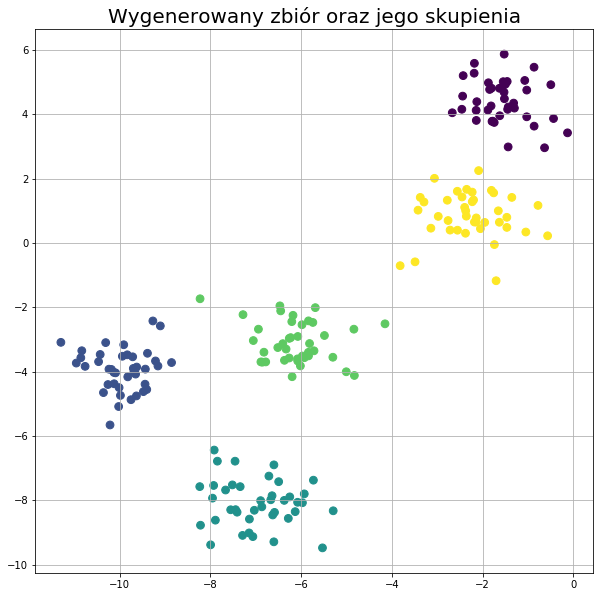

In [2]:
X, y = make_blobs(n_samples=200, n_features=2, centers=5, cluster_std=0.7, shuffle=True, random_state=1)

plt.figure(figsize=(10, 10))
plt.title("Wygenerowany zbiór oraz jego skupienia", fontsize=20)
plt.scatter(X[:, 0], X[:, 1], c=y, marker='o', s=60)
plt.grid()
plt.show()

## Badanie optymalnej liczby klastrów

Załóżmy w tym miejscu, że nie mamy pojęcia o optymalnej liczbie klastrów - spróbujmy zbadać jaka jest najlepsza.

Ponieważ algorytmu *k-średnich* użyjemy z modułu *sklearn.cluster* (który dobrze współgra z pozostałymi funkcjonalnościami pakietu) to na nim przebadamy analizę profilu (*silhouette analysis*), która wskaże najbardziej optymalną liczbę klastrów:

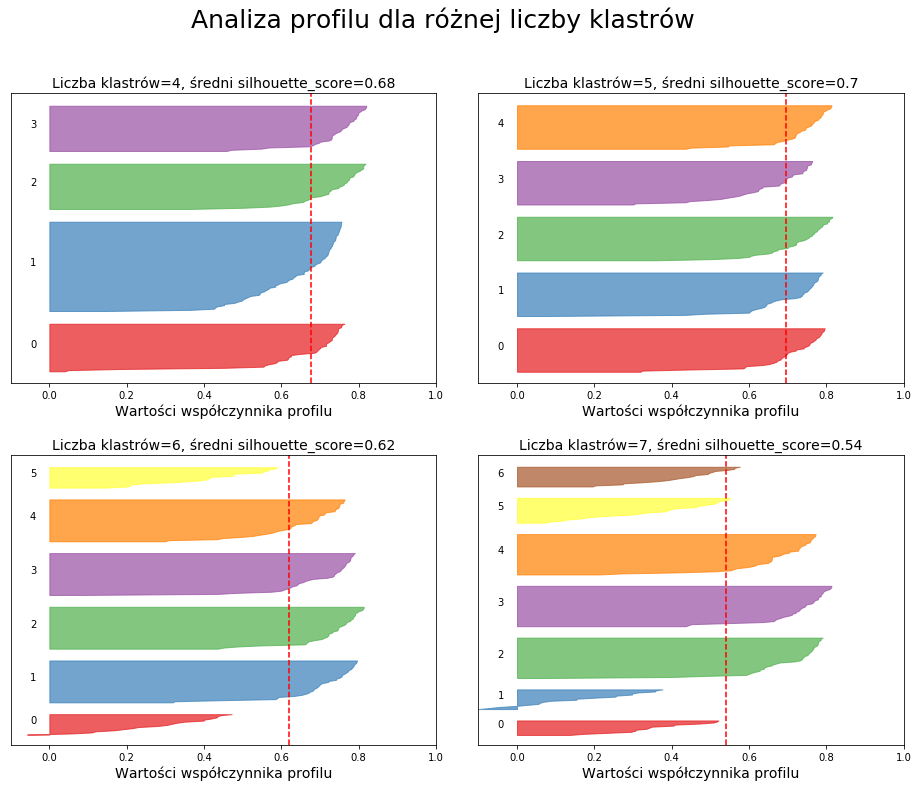

In [3]:
plt.figure(figsize=(16, 12))
for n_clusters in [4, 5, 6, 7]:
    plt.suptitle('Analiza profilu dla różnej liczby klastrów', fontsize=25)
    plt.subplots_adjust(hspace=0.25, wspace=0.1)
    plt.subplot(2, 2, n_clusters-3)
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.Set1(i)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    plt.title(f'Liczba klastrów={n_clusters}, średni silhouette_score={np.round(silhouette_avg, 2)}', 
              fontsize=14)
    plt.xlabel("Wartości współczynnika profilu", fontsize=14)
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([])
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.])

plt.show()

Widać, że uśredniony najlepszy wynik otrzymujemy dla $5$ klastrów. Analogiczny, aczkolwiek o wiele bardziej widoczny, wniosek można wyczytać z *elbow plot* zamieszczonego poniżej:

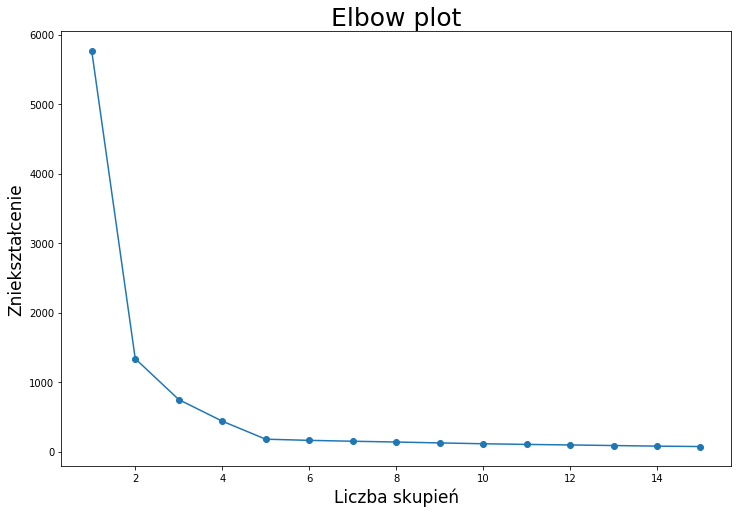

In [4]:
### elbow plot
distortions = []
for i in range(1, 16):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.figure(figsize=(12, 8))
plt.plot(range(1, 16), distortions, marker='o')
plt.xlabel('Liczba skupień', fontsize=17); plt.ylabel('Zniekształcenie', fontsize=17)
plt.title('Elbow plot', fontsize=25)
plt.show()

## Algorytm k-średnich

In [5]:
%%timeit
kmean = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_kmean = kmean.fit_predict(X)

14.2 ms ± 191 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


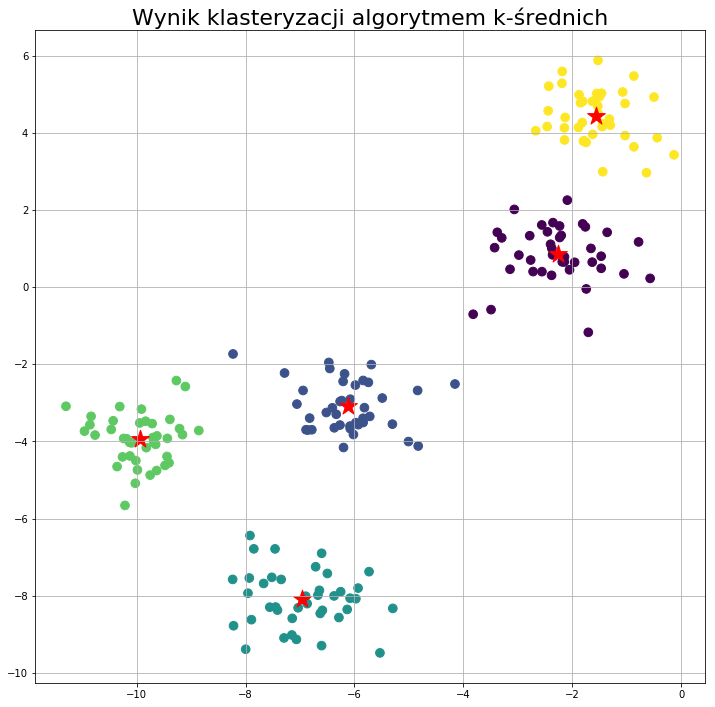

In [6]:
kmean = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_kmean = kmean.fit_predict(X)

plt.figure(figsize=(12, 12))
plt.title("Wynik klasteryzacji algorytmem k-średnich", fontsize=22)
plt.scatter(X[:, 0], X[:, 1], c=y_kmean, marker='o', s=75)
plt.scatter(kmean.cluster_centers_[:, 0], kmean.cluster_centers_[:, 1], s=350, marker='*', c='red')
plt.grid()
plt.show()

## Algorytm k-medoidów

W związku z brakiem implementacji algorytmu *k-medoids* w pakiecie *sklearn* trzeba było odnieść się do innych źródeł. W pakiecie *pyclustering* można znaleźć wiele metod klasteryzacji, w tym właśnie tę, którą potrzebujemy:

In [13]:
%time
initial_medoids = [1, 2, 100, 130, 199]
kmedoids_instance = kmedoids([list(record) for record in X], initial_medoids)
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 16.7 µs


Jak widać oba algorytmy radzą sobie mniej więcej tak samo szybko z zadaniem klasteryzacji. Niestety, z powodu osobnego pakietu do algorytmu *k-medoids* nie jesteśmy w stanie sprawdzić centra wskazanych klastrów. Ponadto wizualizacja nie będzie wspaniała, ale tylko z takiej możemy skorzystać. Mimo tego widać, że zadanie analizy skupień na posiadanym zbiorze również zakończyło się sukcesem:

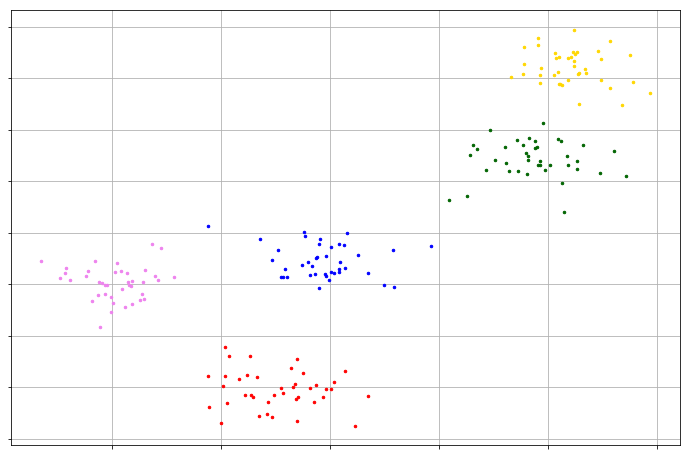

In [8]:
# Display clusters
fig = plt.figure(figsize=(12, 8))
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, [list(record) for record in X])
visualizer.show(figure=fig)
plt.show()